In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import geopandas as gpd
import pandas as pd
import osmnx as ox
import momepy
import fiona
import networkx as nx

# Seed for result reproducability
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_root = './datasets'
!nvidia-smi

/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Tue Mar 29 20:29:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:21:00.0 Off |                  N/A |
| 24%   35C    P8    20W / 250W |     80MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Construction

In [6]:
full_dataset_label = 'No Bounds'

# training_places = ['Coventry'] # for testing
training_places = ['Leeds', 'Cambridge', 'Coventry', 'Bristol', 'Leicester', 'Glasgow']
# training_places = [full_dataset_label]
test_places = ['Leeds', 'Manchester', 'Sheffield', 'Liverpool', 'Edinburgh', 'Wales']
true_inductive = ['nashville indiana', 'belfast', 'manhattan', 'singapore', 'tokyo']

# Fields to ignore
meridian_fields = ['meridian_id', 'meridian_gid', 'meridian_code',
                   'meridian_osodr', 'meridian_number', 'meridian_road_name',
                   'meridian_indicator', 'meridian_class', 'meridian_class_scale']
census_geom_fields = ['wz11cd', 'lsoa11nm', 'msoa11nm',
                      'oa11cd', 'lsoa11cd', 'msoa11cd'] # Allowed: lad11cd, lad11nm
misc_fields = ['id']
ignore_fields = meridian_fields + census_geom_fields + misc_fields


unnorm_feature_fields = ['metres', 'choice2km', 'nodecount2km', 'integration2km',
                      'choice10km', 'nodecount10km','integration10km',
                      'choice100km','nodecount100km','integration100km']
rank_fields = ['choice2kmrank', 'choice10kmrank','integration10kmrank', 'integration2kmrank']
log_fields = ['choice2kmlog','choice10kmlog','choice100kmlog']
all_feature_fields = unnorm_feature_fields + rank_fields + log_fields

# Post-processing features
feats = ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km',
         'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km',
         'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank',
         'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']

# dictionary caches - RELOADING THIS CELL DELETES GRAPH CACHES
loaded_gdfs = {}
loaded_graphs={}

# Projection
from pyproj import CRS, Transformer
crs_proj = CRS.from_epsg(27700)
crs_4326 = CRS("WGS84")
transformer = Transformer.from_crs(crs_4326, crs_proj)

def proj_and_reorder_bounds(bbox):
  S, W, N, E = bbox
  [S, N], [W, E] = transformer.transform([S, N], [W, E])
  return (S, W, N, E)


In [3]:
# Load full dataset
full_gdf = gpd.read_file('./OpenMapping-gb-v1_gpkg/gpkg/ssx_openmapping_gb_v1.gpkg',
                    ignore_fields=ignore_fields)
included_places = full_gdf['lad11nm'].unique()
included_places

array(['Isle of Wight', 'Wycombe', None, 'Enfield', 'Slough',
       'South Bucks', 'Hillingdon', 'Ealing', 'Chiltern', 'Copeland',
       'Windsor and Maidenhead', 'Plymouth', 'South Hams', 'Oxford',
       'Waltham Forest', 'Mendip', 'Dudley', 'Cotswold', 'Erewash',
       'Redbridge', 'Epping Forest', 'Test Valley',
       'Basingstoke and Deane', 'South Gloucestershire', 'Woking',
       'Broxbourne', 'Wolverhampton', 'Wiltshire', 'Swindon',
       'Bath and North East Somerset', 'Trafford', 'Salford',
       'South Staffordshire', 'West Oxfordshire', 'Malvern Hills',
       'Vale of White Horse', 'South Kesteven', 'North Kesteven',
       'Guildford', 'Southwark', 'Chichester', 'Waverley', 'Elmbridge',
       'Forest of Dean', 'Tewkesbury', 'Charnwood', 'Sheffield',
       'Ashfield', 'North West Leicestershire', 'North East Derbyshire',
       'Stroud', 'Shropshire', 'Telford and Wrekin', 'Horsham',
       'City of London', 'Newcastle-under-Lyme', 'Stafford',
       'Stoke-on-Tre

In [1]:
from shapely.geometry import LineString

# Data processing parameters
radii = { # metres
    '2km': 2000,
    '10km': 10000,
    '100km': 100000
}
radius = '2km' # for larger radii either turn off boundary masking or widen bbox
modifier = 'rank'
geoms = 2
classes = 0
osmnx_buffer = 10000

def load_gdf(place=training_places[0], verbose=False): #(W, S, E, N)
    """Geodataframe (gdf) loader with caching"""
    if place in included_places:
        # Retrieve matching rows corresponding to the Local Authority
        gdf = full_gdf.query(f'lad11nm == "{place}"').copy()
    elif place == full_dataset_label:
        # Read full dataset without boundaries
        gdf = full_gdf.copy()
    else:
        # Load gdf from osmnx (for testing only, graph will lack target attr)
        # Actually uses the Nominatim API:
        # https://nominatim.org/release-docs/latest/api/Overview/
        g = ox.graph.graph_from_place(place, buffer_dist=osmnx_buffer)
        g = ox.projection.project_graph(g)
        gdf = ox.utils_graph.graph_to_gdfs(g, nodes=False)
        gdf = gdf.rename(columns={'length': 'metres'})
        return gdf

    if verbose:
        print(f'{gdf.size} geometries retrieved from {place}')

    loaded_gdfs[place] = gdf
    return gdf


def add_boundary_mask(gdf, place, rad, verbose=False):
    """Add flag column to indicate geometries within 'rad' of the bounding box
       No masking if loading full dataset"""
    if place == full_dataset_label:
        s = True
        masked_count = 0
    else:
        if place in bboxes:
            # Use defined boundaries
            S, W, N, E = proj_and_reorder_bounds(bboxes[place])
        else:
            # Use total bounds (For osmnx-loaded graphs)
            W, S, E, N = gdf.geometry.total_bounds
        boundary_line = LineString([(S, W), (N, W), (N, E), (S, E), (S, W)])
        boundary = boundary_line.buffer(radii[rad])
        s = gdf.geometry.disjoint(boundary)
        masked_count = gdf.size - s.sum()
    if verbose:
        print(f'Masking {masked_count} out of {gdf.size} geometries within boundary buffer')
    gdf['boundary_mask'] = s


NameError: name 'training_places' is not defined

# Construct SSx Graph dataset

In [2]:
import os
import os.path as osp
from itertools import chain
from virtual_node import VirtualNode
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import OneHotDegree, NormalizeFeatures
from torch_geometric.data import Batch, InMemoryDataset, download_url, extract_zip

# For one hot encoding of node degrees
max_deg = 16

def process_graph(g, feature_fields=[]):
    node_fields = set(chain.from_iterable(d.keys() for *_, d in g.nodes(data=True)))
    to_delete_fields = [field for field in node_fields if field not in feature_fields]
    for _, d in g.nodes(data=True):
        # remove non float-attributes
        for attr in to_delete_fields:
            del d[attr]
    return g

def load_graph(place, feature_fields=[], reload=True, verbose=False):
  if verbose:
    print(f'Loading graph of {place}...')
  key = (place)
  if key in loaded_graphs and reload:
    g = loaded_graphs[key]
    if verbose:
        print('Loaded existing graph.')
  else:
    gdf = load_gdf(place, verbose=verbose)
    G = momepy.gdf_to_nx(gdf, approach='dual')
    G = process_graph(G, feature_fields)
    if verbose:
      print(f'Generated graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')
    node_attrs = set(chain.from_iterable(d.keys() for *_, d in G.nodes(data=True)))
    edge_attrs = set(chain.from_iterable(d.keys() for *_, d in G.edges(data=True)))
    if verbose:
        # List node and edge attributes
        print(f'Node attributes: {node_attrs}')
        print(f'Edge Attributes: {edge_attrs}')
    
    # If no node attributes, node degree will be added later
    # Edge attribute (angle) is always included due to momepy
    if len(node_attrs) > 0:
        g = from_networkx(G, group_node_attrs=list(node_attrs), group_edge_attrs=list(edge_attrs))
    else:
        g = from_networkx(G, group_edge_attrs=list(edge_attrs))
    loaded_graphs[key] = g
  return g

def print_graph_properties(g):
    # Gather some statistics about the graph.
    print(f'Number of nodes: {g.num_nodes}')
    print(f'Number of edges: {g.num_edges}')
    print(f'Average node degree: {g.num_edges / g.num_nodes:.2f}')
    print(f'Number of training nodes: {g.train_mask.sum()}')
    print(f'Training node label rate: {int(g.train_mask.sum()) / g.num_nodes:.2f}')
    print(f'Has isolated nodes: {g.has_isolated_nodes()}')
    print(f'Has self-loops: {g.has_self_loops()}')
    print(f'Is undirected: {g.is_undirected()}')

def load_graphs(df, la_col_name, virtual_node=False,
                feature_fields=[], target_attrs=[]):
    print('Test')
    data_list = []
    la_names = df[la_col_name].unique()
    for place in included_places:
        if place in la_names:
            g = load_graph(place, feature_fields, verbose=True)
            
            # Normalize node features
            g = NormalizeFeatures()(g)
            
            # Add virtual node
            if virtual_node:
                g = VirtualNode()(g)
            
            # One hot encode degree if no node features
            if g.num_node_features == 0:
                g = OneHotDegree(max_deg)(g)
            
            # Get row corresponding to place
            row = df.query(f'`{la_col_name}` == "{place}"')

            # Obtain target attribute(s)
            ys = []
            for target in target_attrs:
                ys.append(row.iloc[0][target])
            
            # Set graph target attribute
            g.y = torch.tensor([ys])
            data_list.append(g)
    return data_list


In [15]:
def split_row(row):
    code1, code2 = row.iloc[0]['Code'].split('/')
    name1, name2 = row.iloc[0]['Name'].split('/')
    row1 = row.copy()
    row1['Code'] = code1
    row1['Name'] = name1
    row2 = row.copy()
    row2['Code'] = code2
    row2['Name'] = name2
    return pd.concat([row1, row2])
    
def load_city_cluster_df():
    df = pd.read_excel('datasets/clustermembershipv2.xls', sheet_name='Clusters by Local Authority', header=9)
    df = df[['Code', 'Name', 'Supergroup Code', 'Group Code', 'Subgroup Code']]
    
    # Remove last two lines (empty rows)
    df = df[:-2]
    
    # Unmerge London/Westminster and Cornwall/Isles of Scilly
    lon_wes_row = df.query('Name == "City of London/Westminster"')
    corn_isles_row = df.query('Name == "Cornwall/Isles of Scilly"')
    df = pd.concat([df, split_row(lon_wes_row), split_row(corn_isles_row)])
        
    # Turn categorical data into numeric
    df['Supergroup Code'] = df['Supergroup Code'].astype('category')
    df['Group Code'] = df['Group Code'].astype('category')
    df['Subgroup Code'] = df['Subgroup Code'].astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    # subtract one to make it 0 indexed
    
    return df

def load_gva_df(): 
    gva_df = pd.read_excel('datasets/regionalgvaibylainuk.xls', sheet_name='Total GVA', header=2)
    return gva_df

def load_deprivation_df():
    sheets_and_cols = {
        'IMD': 'IMD',
        'Income': 'Income',
        'Employment': 'Employment',
        'Education': 'Education, Skills and Training',
        'Health': 'Health Deprivation and Disability',
        'Crime': 'Crime',
        'Barriers': 'Barriers to Housing and Services',
        'Living': 'Living Environment',
        'IDACI': 'Income Deprivation Affecting Children Index (IDACI)',
        'IDAOPI': 'Income Deprivation Affecting Older People (IDAOPI)',
    }
    id_cols = ['Local Authority District code (2013)', 'Local Authority District name (2013)']
    dep_metrics = ['Average rank', 'Average score']
    
    out_df = None
    for sheet in sheets_and_cols:
        dep_df = pd.read_excel('datasets/File_10_ID2015_Local_Authority_District_Summaries.xlsx',
                               sheet_name=sheet, header=0)
        cols_to_read = id_cols + [f'{sheets_and_cols[sheet]} - {metric}' for metric in dep_metrics]  
        dep_df = dep_df[cols_to_read]
        if out_df is not None:
            out_df = out_df.merge(dep_df, on=id_cols)
        else:
            out_df = dep_df
    return out_df
    


# gva_data_list = load_graphs(load_gva_df(), 'LA_name', target_attrs=[2015])
# torch.save(gva_data_list, 'datasets/ssx_gva_dataset.pt')

# city_cluster_data_list = load_graphs(load_city_cluster_df(), 'Name', feature_fields=all_feature_fields,
#                             target_attrs=['Supergroup Code', 'Group Code', 'Subgroup Code'])

# torch.save(city_cluster_data_list, 'datasets/ssx_cities_dataset_norm.pt')

df = load_deprivation_df()
df

,Local Authority District code (2013),Local Authority District name (2013),IMD - Average rank,IMD - Average score,Income - Average rank,Income - Average score,Employment - Average rank,Employment - Average score,"Education, Skills and Training - Average rank","Education, Skills and Training - Average score",...,Crime - Average rank,Crime - Average score,Barriers to Housing and Services - Average rank,Barriers to Housing and Services - Average score,Living Environment - Average rank,Living Environment - Average score,Income Deprivation Affecting Children Index (IDACI) - Average rank,Income Deprivation Affecting Children Index (IDACI) - Average score,Income Deprivation Affecting Older People (IDAOPI) - Average rank,Income Deprivation Affecting Older People (IDAOPI) - Average score
0,E06000001,Hartlepool,21886.60,33.178,22711.37,0.239,24876.54,0.211,20101.48,30.510,...,17360.29,0.078,8132.08,13.128,6723.11,8.260,22579.19,0.307,20692.34,0.244
1,E06000002,Middlesbrough,23562.71,40.216,23472.98,0.268,24731.49,0.216,22728.01,40.640,...,23468.17,0.633,13789.08,18.316,10521.28,12.907,24366.41,0.357,19587.43,0.253
2,E06000003,Redcar and Cleveland,19716.01,28.567,20485.88,0.204,23187.19,0.186,19185.28,27.875,...,16326.90,-0.013,8251.14,12.863,6150.27,7.923,21220.74,0.273,16755.19,0.189
3,E06000004,Stockton-on-Tees,17046.82,24.625,17740.60,0.177,19639.45,0.156,16660.09,24.637,...,13642.44,-0.263,12889.76,17.844,5674.10,7.068,18134.25,0.226,15487.05,0.179
4,E06000005,Darlington,17423.32,23.639,18141.06,0.168,20106.98,0.150,16385.06,22.569,...,19412.70,0.224,7457.80,12.346,9002.91,10.710,18234.49,0.215,15816.84,0.176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,E09000029,Sutton,12063.57,14.579,13697.34,0.111,12238.97,0.086,11629.13,12.576,...,18649.65,0.163,15338.03,19.784,16296.96,19.062,15248.39,0.159,12180.12,0.129
322,E09000030,Tower Hamlets,25486.40,35.657,25624.12,0.253,19994.04,0.138,16654.45,18.831,...,25365.55,0.762,29089.59,37.748,27007.76,39.823,28983.38,0.393,30626.21,0.497
323,E09000031,Waltham Forest,23744.54,30.190,22759.13,0.193,19861.43,0.128,17236.42,18.693,...,27260.33,0.860,29428.98,38.435,25539.47,35.439,23811.53,0.270,22673.23,0.251
324,E09000032,Wandsworth,15774.73,18.295,15537.30,0.127,11170.92,0.079,7358.71,7.250,...,22396.34,0.439,19644.23,24.595,26639.14,38.202,17873.64,0.207,21646.04,0.234


## Data Processing & Transformations

In [17]:
print('Test')

Test


## Load saved dataset and process into dataloader

In [19]:
from torch_geometric.loader import DataLoader
torch.manual_seed(12345)

def print_dataset_stats(dataset):
    print(f'Number of graphs: {len(dataset)}')
    data = dataset[0]  # Get the first graph object.
    print()
    print(data)
    print('=============================================================')

    # Gather some statistics about the first graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of node features: {data.num_node_features}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Number of edge features: {data.num_edge_features}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

def process_dataset(dataset, split=0.8, batch_size=64, verbose=False):
    # Train-test split
    idx = torch.randperm(len(dataset))
    split_idx = math.floor(split * len(dataset))
    train_idx = idx[:split_idx]
    test_idx = idx[split_idx:]
    train_dataset = [dataset[i] for i in train_idx]
    test_dataset = [dataset[i] for i in test_idx]
    if verbose:
        print(f'Number of training graphs: {len(train_dataset)}')
        print(f'Number of test graphs: {len(test_dataset)}')
    
    # Load graphs into dataloader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    if verbose:
        for step, data in enumerate(train_loader):
            print(f'Step {step + 1}:')
            print('=======')
            print(f'Number of graphs in the current batch: {data.num_graphs}')
            print(data)
            print()

    return dataset, train_loader, test_loader

def get_data_stats(dataset, target_index):
    num_node_features = dataset[0].num_node_features
    try:
        targets = [data.y[0][target_index].item() for data in dataset]
    except IndexError:
        return num_node_features, 1
    return num_node_features, max(targets) + 1 # 0-indexed


dataset = torch.load('datasets/ssx_cities_dataset_normalized.pt')
dataset, train_loader, test_loader = process_dataset(dataset, verbose=True)

Number of training graphs: 277
Number of test graphs: 70
Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1852666], x=[320225, 17], edge_attr=[1852666, 1], edge_type=[1852666], y=[64, 3], batch=[320225], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1997694], x=[344754, 17], edge_attr=[1997694, 1], edge_type=[1997694], y=[64, 3], batch=[344754], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2076266], x=[345558, 17], edge_attr=[2076266, 1], edge_type=[2076266], y=[64, 3], batch=[345558], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1849294], x=[316517, 17], edge_attr=[1849294, 1], edge_type=[1849294], y=[64, 3], batch=[316517], ptr=[65])

Step 5:
Number of graphs in the current batch: 21
DataBatch(edge_index=[2, 443314], x=[77694, 17], edge_attr=[443314, 1], edge_type=[443314], y=[21, 3], batch=[77694], ptr=[22])



## OLS with Mean SSx Metrics

In [ ]:
from sklearn.linear_model import LinearRegression

num_node_features = dataset[0].num_node_features
X = np.zeros((len(dataset), num_node_features))
y = np.zeros(len(dataset))

# Get mean vectors for each graph
for i, graph in enumerate(dataset):
    X[i] = graph.x.mean(dim=0) # shape [17]
    y[i] = graph.y[0]

reg = LinearRegression().fit(X, y)
print(reg.score(X, y)) # transductive
pd.DataFrame({ 'features': feature_fields, 'coefficients': reg.coef_ })

# OLS with Link Pred Metrics

In [26]:
torch.load('datasets/link_pred_metrics_1_iter.pt').keys()

dict_keys(['Nuneaton and Bedworth'])

In [43]:
from sklearn.linear_model import LinearRegression

def link_pred_regression(link_pred_metric):
    dep_df = load_deprivation_df()
    link_pred_dataset = torch.load('datasets/link_pred_metrics_1_iter.pt')
    
    id_cols = ['Local Authority District name (2013)', 'Local Authority District code (2013)']
    scores = {}
    valid_places = [place for place in dep_df[id_cols[0]] \
                    if place in link_pred_dataset]
    print(valid_places)
    
    if link_pred_metric in list(link_pred_dataset.values())[0]:
        # Retrieve the run-level results
        X = [link_pred_dataset[place][link_pred_metric] for place in valid_places]
    else:
        # Retrieve and obtain the average inductive result over test places
        X = []
        for train_place in valid_places:
            metric_acc = []
            for test_place in link_pred_dataset[train_place]['tests']:
                metric = link_pred_dataset[train_place]['tests'][test_place][link_pred_metric]
                metric_acc.append(metric)
            X.append([sum(metric_acc) / len(metric_acc)])
    
    # Obtain deprivation statistics corresponding to retrieved metrics
    dep_df = dep_df.query(f'`{id_cols[0]}` == @valid_places')
    metrics = [col for col in dep_df.columns
               if col not in id_cols]
    
    for metric in metrics:
        Y = dep_df[metric].values
        reg = LinearRegression().fit(X, Y)
        score = reg.score(X, Y)
        scores[metric] = score
        print(f'R score for {metric}: {score}')
    return scores

scores = link_pred_regression('train_auc')                            
scores

['Plymouth', 'Slough', 'Windsor and Maidenhead', 'Isle of Wight', 'Chiltern', 'South Bucks', 'Wycombe', 'Copeland', 'South Hams', 'Oxford', 'Mendip', 'Ealing', 'Enfield', 'Hillingdon', 'Waltham Forest']
R score for IMD - Average rank: 0.20607476068801267
R score for IMD - Average score: 0.23636080015338445
R score for Income - Average rank: 0.21490914834506458
R score for Income - Average score: 0.2674242831754361
R score for Employment - Average rank: 0.04613619879567721
R score for Employment - Average score: 0.039374725044619585
R score for Education, Skills and Training - Average rank: 0.05273854700808622
R score for Education, Skills and Training - Average score: 0.04289300683985364
R score for Health Deprivation and Disability - Average rank: 0.13478310645107694
R score for Health Deprivation and Disability - Average score: 0.13698660458567802
R score for Crime - Average rank: 0.6239643041357243
R score for Crime - Average score: 0.6318451698500016
R score for Barriers to Housing

{'IMD - Average rank': 0.20607476068801267,
 'IMD - Average score': 0.23636080015338445,
 'Income - Average rank': 0.21490914834506458,
 'Income - Average score': 0.2674242831754361,
 'Employment - Average rank': 0.04613619879567721,
 'Employment - Average score': 0.039374725044619585,
 'Education, Skills and Training - Average rank': 0.05273854700808622,
 'Education, Skills and Training - Average score': 0.04289300683985364,
 'Health Deprivation and Disability - Average rank': 0.13478310645107694,
 'Health Deprivation and Disability - Average score': 0.13698660458567802,
 'Crime - Average rank': 0.6239643041357243,
 'Crime - Average score': 0.6318451698500016,
 'Barriers to Housing and Services - Average rank': 0.2291340286251471,
 'Barriers to Housing and Services - Average score': 0.1575293507465344,
 'Living Environment - Average rank': 0.22189575628000668,
 'Living Environment - Average score': 0.16171568051129437,
 'Income Deprivation Affecting Children Index (IDACI) - Average ra

# TSNE visualizations

/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 348 samples in 0.000s...
[t-SNE] Computed neighbors for 348 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 348 / 348
[t-SNE] Mean sigma: 2407881.875207
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.949558
[t-SNE] KL divergence after 1000 iterations: 0.132745


tensor([[1.6021e+02, 1.5132e+03, 1.6610e+02,  ..., 4.1916e+00, 4.5222e+05,
         8.7298e+04],
        [1.7607e+02, 1.1871e+03, 1.5061e+02,  ..., 5.6303e+00, 4.8446e+05,
         1.9388e+05],
        [1.1940e+02, 5.6643e+03, 4.7075e+02,  ..., 5.5866e+00, 5.3290e+05,
         1.9539e+05],
        ...,
        [1.2878e+02, 4.2688e+03, 3.7005e+02,  ..., 4.7765e+00, 6.3555e+05,
         1.6788e+05],
        [1.8291e+02, 1.3880e+03, 1.5450e+02,  ..., 5.1571e+00, 6.3056e+05,
         1.4935e+05],
        [1.3168e+02, 2.0656e+03, 2.3951e+02,  ..., 5.1180e+00, 4.3551e+05,
         2.8955e+05]])

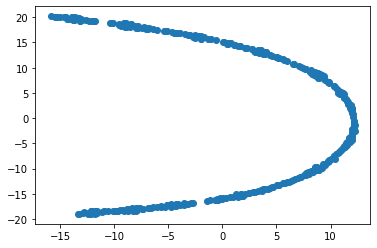

In [13]:
# Original features
from sklearn.manifold import TSNE

def tsne(dataset, include_feats):
    feat_idx = torch.tensor([feats.index(feat) for feat in include_feats])
    features = [torch.index_select(data.x, 1, feat_idx) for data in dataset]
    
    avg_feats = [torch.mean(feats, dim=0) for feats in features]
    avg_feats = torch.stack(avg_feats)
    tsne = TSNE(learning_rate='auto', verbose=1).fit_transform(avg_feats)

    plt.scatter(tsne[:, 0], tsne[:, 1])
    return avg_feats

include_feats = rank_fields # CHANGE THIS
dataset = torch.load('datasets/ssx_dataset.pt')
tsne(dataset, feats)

# Embedded features

# Standard MLP For Classification

### Models

In [20]:
from torch.nn import Linear, Module, Sequential, ModuleList, Conv1d, MaxPool1d
from torch.nn import Identity, ReLU, Sigmoid, Tanh, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GCN2Conv, GraphConv, DynamicEdgeConv, TopKPooling, MLP
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_sort_pool as gsp

activations = {
    'none': (lambda x: x),
    'relu': F.relu,
    'sigmoid': F.sigmoid,
    'tanh': F.tanh,
    'logsoft': (lambda x: F.log_softmax(x, dim=-1))
}

gnn_layers = {
    'gcn': GCNConv,
    'gcnii': GCN2Conv,
    'graph': GraphConv
}

# agg_layers = {
#     'max': global_max_pool,
#     'avg': global_mean_pool
# }


class LinearRegression(Module):
    def __init__(self, in_feats, num_classes):
        super(LinearRegression, self).__init__()
        self.layer = Linear(in_feats, num_classes)

    def forward(self, data):
        x, batch = data.x, data.batch
        x = gap(x, batch)
        
        out = self.layer(x)
        return out

class GraphLinear(Linear):
    def forward(self, data, _):
        return super().forward(data)
    
class GraphMLP(Module):
    def __init__(self, in_feats, h_feats, num_layers, num_classes, act=None):
        super(GraphMLP, self).__init__()
        assert num_layers >= 1
        channel_list = [h_feats] * (num_layers - 1)
        channel_list = [in_feats] + channel_list + [num_classes]
        
        layers = []
        for dims in zip(channel_list[:-1], channel_list[1:]):
            layers.append(Linear(*dims))
            layers.append(ReLU())
        self.act = activations[act]
        self.layer = Sequential(*layers)

    def forward(self, data):
        x, batch = data.x, data.batch
        x = gap(x, batch)
        
        out = self.act(self.layer(x))
        return out


class GNN(Module):
    def __init__(self, in_feats, h_feats, num_classes, num_layers, 
                 act='none', dropout=0.5, type='gcn'):
        super(GNN, self).__init__()
        assert num_layers >= 1
        layer = gnn_layers[type]
        
        self.num_layers = num_layers
        self.lin = Linear(h_feats, num_classes)
        self.dropout = dropout
        self.act = activations[act]
        self.layers = ModuleList()
        channel_list = [h_feats] * num_layers
        channel_list = [in_feats] + channel_list
        for dims in zip(channel_list[:-1], channel_list[1:]):
            self.layers.append(layer(*dims))

    def forward(self, data):
        # data should have the following 3 attributes
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)            
            
        x = gap(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.act(self.lin(x))
        
        return x
    

class TopKGNN(Module):
    def __init__(self, in_feats, h_feats, num_classes, type='graph', act='none'):
        super().__init__()
        gnn_layer = gnn_layers[type]
        
        self.conv1 = gnn_layer(in_feats, h_feats)
        self.pool1 = TopKPooling(h_feats, ratio=0.8)
        self.conv2 = gnn_layer(h_feats, h_feats)
        self.pool2 = TopKPooling(h_feats, ratio=0.8)
        self.conv3 = gnn_layer(h_feats, h_feats)
        self.pool3 = TopKPooling(h_feats, ratio=0.8)

        self.lin1 = torch.nn.Linear(h_feats * 2, h_feats)
        self.lin2 = torch.nn.Linear(h_feats, h_feats // 2)
        self.lin3 = torch.nn.Linear(h_feats // 2, num_classes)
        
        self.act = activations[act]

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        # x = self.lin3(x)
        x = self.act(self.lin3(x))
        return x

class DGCNN(torch.nn.Module):
    def __init__(self, in_feats, hidden_channels, num_classes, num_layers,
                 train_dataset, GNN=GCNConv, k=0.6, act='none'):
        super().__init__()

        if k < 1:  # Transform percentile to number.
            num_nodes = sorted([data.num_nodes for data in train_dataset])
            k = num_nodes[int(math.ceil(k * len(num_nodes))) - 1]
            k = max(10, k)
        self.k = int(k)

        self.convs = ModuleList()
        self.convs.append(GNN(in_feats, hidden_channels))
        for i in range(0, num_layers - 1):
            self.convs.append(GNN(hidden_channels, hidden_channels))
        self.convs.append(GNN(hidden_channels, 1))

        conv1d_channels = [16, 32]
        total_latent_dim = hidden_channels * num_layers + 1
        conv1d_kws = [total_latent_dim, 5]
        self.conv1 = Conv1d(1, conv1d_channels[0], conv1d_kws[0],
                            conv1d_kws[0])
        self.maxpool1d = MaxPool1d(2, 2)
        self.conv2 = Conv1d(conv1d_channels[0], conv1d_channels[1],
                            conv1d_kws[1], 1)
        dense_dim = int((self.k - 2) / 2 + 1)
        dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        self.mlp = MLP([dense_dim, 128, num_classes], dropout=0.5, batch_norm=False)
        self.act = activations[act]

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        xs = [x]
        for conv in self.convs:
            xs += [conv(xs[-1], edge_index).tanh()]
        x = torch.cat(xs[1:], dim=-1)

        # Global pooling.
        x = gsp(x, batch, self.k)
        x = x.unsqueeze(1)  # [num_graphs, 1, k * hidden]
        x = self.conv1(x).relu()
        x = self.maxpool1d(x)
        x = self.conv2(x).relu()
        x = x.view(x.size(0), -1)  # [num_graphs, dense_dim]

        return self.act(self.mlp(x))


class GNNBetMLP(Module):
    def __init__(self, nhid,dropout):
        super(GNNBetMLP, self).__init__()
        self.dropout = dropout
        self.linear1 = torch.nn.Linear(nhid,2*nhid)
        self.linear2 = torch.nn.Linear(2*nhid,2*nhid)
        self.linear3 = torch.nn.Linear(2*nhid,1)


    def forward(self,input_vec,dropout):

        score_temp = F.relu(self.linear1(input_vec))
        score_temp = F.dropout(score_temp,self.dropout)
        score_temp = F.relu(self.linear2(score_temp))
        score_temp = F.dropout(score_temp,self.dropout)
        score_temp = self.linear3(score_temp)

        return score_temp
    

# Only for single output
class GNNBetFullMLP(GNN):
    def __init__(self, in_feats, h_feats, num_layers, dropout, agg='gcn'):
        super(GNNBetFullMLP, self).__init__(in_feats, h_feats, h_feats, 
                                            num_layers, dropout=dropout, type=agg)
        self.score_layer = GNNBetMLP(h_feats * num_layers, self.dropout)

    def forward(self, data):
        # data should have the following 3 attributes
        x, edge_index, batch = data.x, data.edge_index, data.batch
        embeddings = []
        
        #Layers for aggregation operation
        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.normalize(x, p=2, dim=1)
            x_agg = gap(x, batch)
            embeddings.append(x_agg)
            
        
        full_embedding = torch.cat(embeddings, dim=1)
        score = self.score_layer(full_embedding, self.dropout)
        
        return score

## Graph Regression/Classification

In [21]:
from sklearn.metrics import r2_score

learning_rate = 0.0002
h_feats = 32
target_index = 0
dropout = 0.6
num_node_features, num_classes = get_data_stats(train_loader.dataset, target_index)
num_layers = 3

model = DGCNN(num_node_features, h_feats, num_classes, num_layers, train_loader.dataset)
# model = GNNBetFullMLP(num_node_features, h_feats, num_layers, dropout)
# model = GNN(num_node_features, h_feats, num_classes, num_layers, act='logsoft')
# model = TopKGNN(num_node_features, h_feats, num_classes)
# model = GraphMLP(num_node_features, h_feats, num_layers, num_classes)
# model = LinearRegression(num_node_features, num_classes)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss() if num_classes == 1 else torch.nn.NLLLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data)  # Perform a single forward pass.
        target = data.y.unsqueeze(1).float() if num_classes == 1 else data.y[:,target_index].long()
        loss = criterion(out, target)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data)
        if num_classes == 1:
            out = out.squeeze(1).cpu().detach()
            correct += r2_score(data.y.cpu().detach(), out)  # Check correlation against ground-truth.
        else:
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y[:,target_index]).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive average correlation.

num_epochs = 100
print_every = 1
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if (epoch + 1) % print_every == 0:
            start = len(train_losses) - print_every
            mean_train = np.mean(train_losses[start:])
            mean_test = np.mean(test_losses[start:])
            print(f'Epoch: {epoch + 1:03d}, Train: {mean_train:.4f}, Val: {mean_test:.4f}')
    train_losses.append(train_acc)
    test_losses.append(test_acc)

DGCNN(
  (convs): ModuleList(
    (0): GCNConv(17, 32)
    (1): GCNConv(32, 32)
    (2): GCNConv(32, 32)
    (3): GCNConv(32, 1)
  )
  (conv1): Conv1d(1, 16, kernel_size=(97,), stride=(97,))
  (maxpool1d): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
  (mlp): MLP(77760, 128, 8)
)


/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 001, Train: nan, Val: nan
Epoch: 002, Train: 0.2094, Val: 0.2000
Epoch: 003, Train: 0.2094, Val: 0.2000
Epoch: 004, Train: 0.2094, Val: 0.2000
Epoch: 005, Train: 0.2094, Val: 0.2000
Epoch: 006, Train: 0.2094, Val: 0.2000
Epoch: 007, Train: 0.2094, Val: 0.2000
Epoch: 008, Train: 0.2094, Val: 0.2000
Epoch: 009, Train: 0.2094, Val: 0.2000
Epoch: 010, Train: 0.2094, Val: 0.2000
Epoch: 011, Train: 0.2094, Val: 0.2000
Epoch: 012, Train: 0.2094, Val: 0.2000
Epoch: 013, Train: 0.2094, Val: 0.2000


KeyboardInterrupt: 

In [ ]:
# Load data
g, loader = load_data(training_places, num_val=0.2, num_parts=1024,
                      num_classes=0, batch_size=128,
                      reload=True, verbose=True)
